#### Note
This (guided) project was designed to run on IBM Watson. I have used the Kaggle environment to save the project from getting deleted after the trial period for IBM Watson has expired. This notebook contains all the labs of the final capstone project.

<a href="#assignmentscrape">Link to Assignment: Webscraping</a>
<br /><a href="#assignmentwrang">Link to Assignment: Data Wrangling</a>
<br /><a href="#assignmentsql">Link to Assignment: SQL Notebook for Peer Assignment</a>
<br /><a href="#assignmentviz">Link to Assignment: Exploring and Preparing Data</a>
<br /><a href="#assignmentfolium">Link to Assignment: Analysis with Folium</a>
<br /><a href="https://github.com/karaklis/dash_py/blob/main/spacex_dash_app.py">External Link to Assignment: Interactive Dashboard</a>
<br /><a href="#assignmentpred">Link to Assignment: Machine Learning Prediction</a>

# SpaceX Falcon 9 first stage Landing Prediction

## Lab 1: Collecting the data

In this capstone, we will predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch. In this lab, you will collect and make sure the data is in the correct format from an API. The following is an example of a successful and launch.

## Objectives
In this lab, we will make a get request to the SpaceX API. You will also do some basic data wrangling and formating.

- Request to the SpaceX API
- Clean the requested data

In [1]:
# import libraries
import requests  # for HTTP requests to get data from API
import pandas as pd
import numpy as np
import datetime

# Setting output options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Below we will define a series of helper functions that will help us use the API to extract information using identification numbers in the launch data.

In [2]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
        response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
        Longitude.append(response['longitude'])
        Latitude.append(response['latitude'])
        LaunchSite.append(response['name'])
        
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])
        
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad']) 
            

Now let's start requesting rocket launch data from SpaceX API with the following URL:

In [3]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
# print(response.content)  # Check the content of the response

### Task 1: Request and parse the SpaceX launch data using the GET request

To make the requested JSON results more consistent, we will use the following static response object for this project:

In [4]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'
response.status_code  # 200=successful

200

Now we decode the response content as a Json using .json() and turn it into a Pandas dataframe using .json_normalize(). Using the dataframe data print the first 5 rows

In [5]:
data = pd.json_normalize(response.json())  # convert to flat table
print(data.head())

       static_fire_date_utc  static_fire_date_unix    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False     0.0   
1                      None                    NaN  False     0.0   
2                      None                    NaN  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False     0.0   
4                      None                    NaN  False     0.0   

                     rocket success  \
0  5e9d0d95eda69955f709d1eb   False   
1  5e9d0d95eda69955f709d1eb   False   
2  5e9d0d95eda69955f709d1eb   False   
3  5e9d0d95eda69955f709d1eb    True   
4  5e9d0d95eda69955f709d1eb    True   

                                                                                                            failures  \
0                                                [{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]   
1            [{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutd

We notice that a lot of the data are IDs. For example the rocket column has no information about the rocket just an identification number.

We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns rocket, payloads, launchpad, and cores.

In [6]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

- From the rocket we would like to learn the booster name
- From the payload we would like to learn the mass of the payload and the orbit that it is going to
- From the launchpad we would like to know the name of the launch site being used, the longitude, and the latitude.
- From cores we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

The data from these requests will be stored in lists and will be used to create a new dataframe.

In [7]:
# Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [8]:
# Call getBoosterVersion
getBoosterVersion(data)
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [9]:
# Call getLaunchSite
getLaunchSite(data)

# Call getPayloadData
getPayloadData(data)

# Call getCoreData
getCoreData(data)

In [10]:
# combine the columns into a dictionary
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


Then, we need to create a Pandas data frame from the dictionary launch_dict.

In [11]:
data_falcon9 = pd.DataFrame(launch_dict)
print(data_falcon9.head())

   FlightNumber        Date BoosterVersion  PayloadMass Orbit  \
0             1  2006-03-24       Falcon 1         20.0   LEO   
1             2  2007-03-21       Falcon 1          NaN   LEO   
2             4  2008-09-28       Falcon 1        165.0   LEO   
3             5  2009-07-13       Falcon 1        200.0   LEO   
4             6  2010-06-04       Falcon 9          NaN   LEO   

        LaunchSite    Outcome  Flights  GridFins  Reused   Legs LandingPad  \
0  Kwajalein Atoll  None None        1     False   False  False       None   
1  Kwajalein Atoll  None None        1     False   False  False       None   
2  Kwajalein Atoll  None None        1     False   False  False       None   
3  Kwajalein Atoll  None None        1     False   False  False       None   
4     CCSFS SLC 40  None None        1     False   False  False       None   

   Block  ReusedCount    Serial   Longitude   Latitude  
0    NaN            0  Merlin1A  167.743129   9.047721  
1    NaN            0  Mer

### Task 2: Filter the dataframe to only include Falcon 9 launches

Finally we will remove the Falcon 1 launches keeping only the Falcon 9 launches. Filter the data dataframe using the BoosterVersion column to only keep the Falcon 9 launches. Save the filtered data to a new dataframe called data_falcon9.

In [12]:
print(data_falcon9['BoosterVersion'].value_counts())
data_falcon9 = data_falcon9[data_falcon9['BoosterVersion']=='Falcon 9']
print(data_falcon9['BoosterVersion'].value_counts())


Falcon 9    90
Falcon 1     4
Name: BoosterVersion, dtype: int64
Falcon 9    90
Name: BoosterVersion, dtype: int64


Now that we have removed some values we should reset the FlgihtNumber column

In [13]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


## Data Wrangling

We can see below that some of the rows are missing values in our dataset

In [14]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

Before we can continue we must deal with these missing values. The LandingPad column will retain None values to represent when landing pads were not used.

### Task 3: Dealing with Missing Values

Calculate below the mean for the PayloadMass using the .mean(). Then use the mean and the .replace() function to replace np.nan values in the data with the mean you calculated.

In [15]:
data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].fillna(data_falcon9['PayloadMass'].mean())
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [16]:
# data_falcon9.to_csv('dataset_part_1.csv', index=False)

<p id="assignmentscrape" />

## Lab 2: Web scraping Falcon 9 and Falcon Heavy Launches Records from Wikipedia

In this lab, we will be performing web scraping to collect Falcon 9 historical launch records from a Wikipedia page titled `List of Falcon 9 and Falcon Heavy launches`

[https://en.wikipedia.org/wiki/List_of_Falcon\_9\_and_Falcon_Heavy_launches](https://en.wikipedia.org/wiki/List_of_Falcon\_9\_and_Falcon_Heavy_launches?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01)

## Objectives

Web scrap Falcon 9 launch records with BeautifulSoup:

Extract a Falcon 9 launch records HTML table from Wikipedia
Parse the table and convert it into a Pandas data frame
First let's import required packages for this lab

In [17]:
import sys
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

and we will provide some helper functions for you to process web scraped HTML table

In [18]:
def date_time(table_cells):  # returns data and time from the HTML table cell
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):  # returns the booster version from the HTML table cell
    return ''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])

def landing_status(table_cells):  # returns the landing status from the HTML table cell
    return [i for i in table_cells.strings][0]

def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):  # returns the landing status from the HTML table cell
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    


To keep the lab tasks consistent, you will be asked to scrape the data from a snapshot of the List of Falcon 9 and Falcon Heavy launches Wikipage updated on 9th June 2021

In [19]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

### TASK 1: Request the Falcon9 Launch Wiki page from its URL

First, let's perform an HTTP GET method to request the Falcon9 Launch HTML page, as an HTTP response.

In [20]:
# use requests.get() method with the provided static_url
# assign the response to a object
r = requests.get(static_url)
data = r.text

Create a BeautifulSoup object from the HTML response

In [21]:
# Use BeautifulSoup() to create a BeautifulSoup object from a response text content
soup = BeautifulSoup(data,"html.parser")

Print the page title to verify if the BeautifulSoup object was created properly

In [22]:
print(soup.title)

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>


### TASK 2: Extract all column/variable names from the HTML table header

Next, we want to collect all relevant column names from the HTML table header

Let's try to find all tables on the wiki page first.

In [23]:
# Use the find_all function in the BeautifulSoup object, with element type `table`
# Assign the result to a list called `html_tables`
html_tables = soup.find_all('table')


Starting from the third table is our target table contains the actual launch records

In [24]:
# Let's print the third table and check its content
first_launch_table = html_tables[2]
# print(first_launch_table)

Next, we just need to iterate through the `<th>` elements and apply the provided `extract_column_from_header()` to extract column name one by one

In [25]:
column_names = []

# Apply find_all() function with `th` element on first_launch_table
# Iterate each th element and apply the provided extract_column_from_header() to get a column name
# Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names
table_headers = first_launch_table.find_all('th')
# print(table_headers)
for j, table_header in enumerate(table_headers):
    name = extract_column_from_header(table_header)
    if name is not None and len(name) > 0:
        column_names.append(name)
    
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


### TASK 3: Create a data frame by parsing the launch HTML tables

We will create an empty dictionary with keys from the extracted column names in the previous task. Later, this dictionary will be converted into a Pandas dataframe

In [26]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

Next, we just need to fill up the launch_dict with launch records extracted from table rows.

Usually, HTML tables in Wiki pages are likely to contain unexpected annotations and other types of noises, such as reference links B0004.1[8], missing values N/A [e], inconsistent formatting, etc.

To simplify the parsing process, we have provided an incomplete code snippet below to help you to fill up the launch_dict. Please complete the following code snippet with TODOs or you can choose to write your own logic to parse all launch tables:

In [27]:
extracted_row = 0
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
    for rows in table.find_all("tr"):  # get table row 
        if rows.th:  #check to see if first table heading is a number corresponding to launch a number
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        row=rows.find_all('td')  # #get table element
        if flag:  #if it is number save cells in a dictonary 
            extracted_row += 1
            # Flight Number value
            # TODO: Append the flight_number into launch_dict with key `Flight No.`
            launch_dict['Flight No.'].append(flight_number)
            # print(flight_number)
            datatimelist=date_time(row[0])
            
            # Date value
            # TODO: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            # print(date)
            
            # Time value
            # TODO: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            launch_dict['Time'].append(time)
            # print(time)
              
            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            launch_dict['Version Booster'].append(bv)
            # print(bv)
            
            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch Site`
            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)
            # print(launch_site)
            
            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            payload = row[3].a.string
            launch_dict['Payload'].append(payload)
            # print(payload)
            
            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            # print(payload)
            
            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)
            # print(orbit)
            
            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            try:
                customer = row[6].a.string
            except:
                customer = "None"

            launch_dict['Customer'].append(customer)
            # print(customer)
            
            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)
            # print(launch_outcome)
            
            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)
            # print(booster_landing)
            
            # debugging: find length differences
            # print("---------------------------")
            # curr_len = [len(val) for key, val in launch_dict.items()]
            # print(curr_len)
            # print("---------------------------")
print("number of extracted rows: ", extracted_row)

number of extracted rows:  121


After we have filled in the parsed launch record values into launch_dict, we can create a dataframe from it.

In [28]:
df=pd.DataFrame(launch_dict)

In [29]:
# debugging: checking length of lists in dictionary 
for key, val in launch_dict.items():
    print(f"{key}: #: {len(val)}")


Flight No.: #: 121
Launch site: #: 121
Payload: #: 121
Payload mass: #: 121
Orbit: #: 121
Customer: #: 121
Launch outcome: #: 121
Version Booster: #: 121
Booster landing: #: 121
Date: #: 121
Time: #: 121


In [30]:
# df.to_csv('spacex_web_scraped.csv', index=False)
df_scraped = df

<p id="assignmentwrang" />

## Lab 3: Data Wrangling

In this lab, we will perform some Exploratory Data Analysis (EDA) to find some patterns in the data and determine what would be the label for training supervised models.

In the data set, there are several different cases where the booster did not land successfully. Sometimes a landing was attempted but failed due to an accident; for example, True Ocean means the mission outcome was successfully landed to a specific region of the ocean while False Ocean means the mission outcome was unsuccessfully landed to a specific region of the ocean. True RTLS means the mission outcome was successfully landed to a ground pad False RTLS means the mission outcome was unsuccessfully landed to a ground pad.True ASDS means the mission outcome was successfully landed on a drone ship False ASDS means the mission outcome was unsuccessfully landed on a drone ship.

In this lab we will mainly convert those outcomes into Training Labels with 1 means the booster successfully landed 0 means it was unsuccessful.

In [31]:
# df=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")
df = data_falcon9
print(df.head(10))
# Identify and calculate the percentage of the missing values in each attribute
print(df.isnull().sum()/df.count()*100)
# Identify which columns are numerical and categorical:
print(df.dtypes)


    FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
4              1  2010-06-04       Falcon 9  6123.547647   LEO  CCSFS SLC 40   
5              2  2012-05-22       Falcon 9   525.000000   LEO  CCSFS SLC 40   
6              3  2013-03-01       Falcon 9   677.000000   ISS  CCSFS SLC 40   
7              4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
8              5  2013-12-03       Falcon 9  3170.000000   GTO  CCSFS SLC 40   
9              6  2014-01-06       Falcon 9  3325.000000   GTO  CCSFS SLC 40   
10             7  2014-04-18       Falcon 9  2296.000000   ISS  CCSFS SLC 40   
11             8  2014-07-14       Falcon 9  1316.000000   LEO  CCSFS SLC 40   
12             9  2014-08-05       Falcon 9  4535.000000   GTO  CCSFS SLC 40   
13            10  2014-09-07       Falcon 9  4428.000000   GTO  CCSFS SLC 40   

        Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
4     None None        1     False   False  Fals

### TASK 1: Calculate the number of launches on each site
The data contains several Space X launch facilities: Cape Canaveral Space Launch Complex 40 VAFB SLC 4E , Vandenberg Air Force Base Space Launch Complex 4E (SLC-4E), Kennedy Space Center Launch Complex 39A KSC LC 39A .The location of each Launch Is placed in the column LaunchSite

Next, let's see the number of launches for each site.

In [32]:
df['LaunchSite'].value_counts()

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

Each launch aims to an dedicated orbit, and here are some common orbit types:
- LEO: Low Earth orbit (LEO)is an Earth-centred orbit with an altitude of 2,000 km (1,200 mi) or less (approximately one-third of the radius of Earth), or with at least 11.25 periods per day (an orbital period of 128 minutes or less) and an eccentricity less than 0.25.[2] Most of the manmade objects in outer space are in LEO.
- VLEO: Very Low Earth Orbits (VLEO) can be defined as the orbits with a mean altitude below 450 km. Operating in these orbits can provide a number of benefits to Earth observation spacecraft as the spacecraft operates closer to the observation.
- GTO A geosynchronous orbit is a high Earth orbit that allows satellites to match Earth's rotation. Located at 22,236 miles (35,786 kilometers) above Earth's equator, this position is a valuable spot for monitoring weather, communications and surveillance. Because the satellite orbits at the same speed that the Earth is turning, the satellite seems to stay in place over a single longitude, though it may drift north to south,” NASA wrote on its Earth Observatory website.
- SSO (or SO): It is a Sun-synchronous orbit also called a heliosynchronous orbit is a nearly polar orbit around a planet, in which the satellite passes over any given point of the planet's surface at the same local mean solar time.
- ES-L1 :At the Lagrange points the gravitational forces of the two large bodies cancel out in such a way that a small object placed in orbit there is in equilibrium relative to the center of mass of the large bodies. L1 is one such point between the sun and the earth [5] .
- HEO A highly elliptical orbit, is an elliptic orbit with high eccentricity, usually referring to one around Earth.
- ISS A modular space station (habitable artificial satellite) in low Earth orbit. It is a multinational collaborative project between five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada)
- MEO Geocentric orbits ranging in altitude from 2,000 km (1,200 mi) to just below geosynchronous orbit at 35,786 kilometers (22,236 mi). Also known as an intermediate circular orbit. These are "most commonly at 20,200 kilometers (12,600 mi), or 20,650 kilometers (12,830 mi), with an orbital period of 12 hours
- HEO Geocentric orbits above the altitude of geosynchronous orbit (35,786 km or 22,236 mi) [9]
- GEO It is a circular geosynchronous orbit 35,786 kilometres (22,236 miles) above Earth's equator and following the direction of Earth's rotation
- PO It is one type of satellites in which a satellite passes above or nearly above both poles of the body being orbited (usually a planet such as the Earth

### TASK 2: Calculate the number and occurrence of each orbit

In [33]:
df['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

### TASK 3: Calculate the number and occurence of mission outcome per orbit type
Use the method .value_counts() on the column Outcome to determine the number of landing_outcomes.Then assign it to a variable landing_outcomes.

In [34]:
landing_outcomes = df['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

<code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully  landed to a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed to a drone ship. <code>None ASDS</code> and <code>None None</code> these represent a failure to land.


In [35]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [36]:
# We create a set of outcomes where the second stage did not land successfully:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

### TASK 4: Create a landing outcome label from Outcome column

Using the <code>Outcome</code>, we create a list where the element is zero if the corresponding  row  in  <code>Outcome</code> is in the set <code>bad_outcome</code>; otherwise, it's one. Then assign it to the variable <code>landing_class</code>:

In [37]:
landing_class = [0 if x in bad_outcomes else 1 for x in df['Outcome']]
# landing_class
df['Class']=landing_class
print(df[['Class']].head(8))
print(df["Class"].mean())  # probability of positive outcome 2/3
print(df.head(5))


    Class
4       0
5       0
6       0
7       0
8       0
9       0
10      1
11      1
0.6666666666666666
   FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
4             1  2010-06-04       Falcon 9  6123.547647   LEO  CCSFS SLC 40   
5             2  2012-05-22       Falcon 9   525.000000   LEO  CCSFS SLC 40   
6             3  2013-03-01       Falcon 9   677.000000   ISS  CCSFS SLC 40   
7             4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
8             5  2013-12-03       Falcon 9  3170.000000   GTO  CCSFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
4    None None        1     False   False  False       None    1.0   
5    None None        1     False   False  False       None    1.0   
6    None None        1     False   False  False       None    1.0   
7  False Ocean        1     False   False  False       None    1.0   
8    None None        1     False   False  False       None    1.0

In [38]:
#df.to_csv("dataset_part_2.csv", index=False)
df_wrangled = df

## Lab 4: Analysis with SQL

Note: the original IBM Lab would use IBM Watson with DB2 as database. We will use SQLite3 instead.

The original DB2 instruction can be viewed [here](https://jp-tok.dataplatform.cloud.ibm.com/analytics/notebooks/v2/32f936b3-5cb3-4145-ab62-875e4ec8990f?projectid=884b3943-1b67-4616-bb80-89fdd4e2bbdf&context=cpdaas) (requires login)

<p id="assignmentsql" />

## Assignment: SQL Notebook for Peer Assignment

Introduction
Using this Python notebook you will:

Understand the Spacex DataSet
Load the dataset into the corresponding table in a Db2 database
Execute SQL queries to answer assignment questions

### Overview of the DataSet
SpaceX has gained worldwide attention for a series of historic milestones.

It is the only private company ever to return a spacecraft from low-earth orbit, which it first accomplished in December 2010. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars wheras other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage.

Therefore if we can determine if the first stage will land, we can determine the cost of a launch.

This information can be used if an alternate company wants to bid against SpaceX for a rocket launch.

This dataset includes a record for each payload carried during a SpaceX mission into outer space.

### Download the datasets

This assignment requires you to load the spacex dataset.

In many cases the dataset to be analyzed is available as a .CSV (comma separated values) file, perhaps on the internet. Click on the link below to download and save the dataset (.CSV file):

<a href="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">Spacex DataSet</a>

In [39]:
import sqlite3
import pandas as pd
print(sqlite3.version)
print(sqlite3.sqlite_version)

2.6.0
3.37.2


### Load dataset, prepare and store it in database table

Change the Date Format by manually typing DD-MM-YYYY and timestamp format as DD-MM-YYYY HH:MM:SS.

Here you should place the cursor at Date field and manually type as DD-MM-YYYY.

Change the PAYLOAD_MASS__KG_ datatype to INTEGER.


In [40]:
# get dataset into pandas dataframe
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01"
df = pd.read_csv(url)
# remove spaces in columns name
df.columns = df.columns.str.replace(' ','_')

# convert timestamp strings to date and time format
df['Date'] = pd.to_datetime(df['Date'], errors="coerce", format="%d-%m-%Y")

print(df.dtypes)
print(df.head())



Date                 datetime64[ns]
Time_(UTC)                   object
Booster_Version              object
Launch_Site                  object
Payload                      object
PAYLOAD_MASS__KG_             int64
Orbit                        object
Customer                     object
Mission_Outcome              object
Landing__Outcome             object
dtype: object
        Date Time_(UTC) Booster_Version  Launch_Site  \
0 2010-06-04   18:45:00  F9 v1.0  B0003  CCAFS LC-40   
1 2010-12-08   15:43:00  F9 v1.0  B0004  CCAFS LC-40   
2 2012-05-22   07:44:00  F9 v1.0  B0005  CCAFS LC-40   
3 2012-10-08   00:35:00  F9 v1.0  B0006  CCAFS LC-40   
4 2013-03-01   15:10:00  F9 v1.0  B0007  CCAFS LC-40   

                                                         Payload  \
0                           Dragon Spacecraft Qualification Unit   
1  Dragon demo flight C1, two CubeSats, barrel of Brouere cheese   
2                                          Dragon demo flight C2   
3                

In [41]:
# create sqlite table and upload data into it
conn = sqlite3.connect(':memory:')  # in memory database
df.to_sql(name="spacexdata", con=conn, if_exists="replace")

q = pd.read_sql('select * from spacexdata', conn)
q

,index,Date,Time_(UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing__Outcome
0,0,2010-06-04 00:00:00,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
1,1,2010-12-08 00:00:00,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2,2,2012-05-22 00:00:00,07:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
3,3,2012-10-08 00:00:00,00:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
4,4,2013-03-01 00:00:00,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt
...,...,...,...,...,...,...,...,...,...,...,...
96,96,2020-11-05 00:00:00,23:24:23,F9 B5B1062.1,CCAFS SLC-40,"GPS III-04 , Crew-1",4311,MEO,USSF,Success,Success
97,97,2020-11-16 00:00:00,00:27:00,F9 B5B1061.1,KSC LC-39A,"Crew-1, Sentinel-6 Michael Freilich",12500,LEO (ISS),NASA (CCP),Success,Success
98,98,2020-11-21 00:00:00,17:17:08,F9 B5B1063.1,VAFB SLC-4E,"Sentinel-6 Michael Freilich, Starlink 15 v1.0",1192,LEO,NASA / NOAA / ESA / EUMETSAT,Success,Success
99,99,2020-11-25 00:00:00,02:13:00,F9 B5 B1049.7,CCAFS SLC-40,"Starlink 15 v1.0, SpaceX CRS-21",15600,LEO,SpaceX,Success,Success


## Tasks

Now we write and execute SQL queries to solve the assignment tasks.

### Task 1
Display the names of the unique launch sites in the space mission

In [42]:
q = pd.read_sql('select distinct Launch_Site from spacexdata', conn)
q

,Launch_Site
0,CCAFS LC-40
1,VAFB SLC-4E
2,KSC LC-39A
3,CCAFS SLC-40


### Task 2
Display 5 records where launch sites begin with the string 'CCA'¶

In [43]:
q = pd.read_sql("select * from spacexdata where Launch_Site like 'CCA%' limit 5", conn)
q

,index,Date,Time_(UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing__Outcome
0,0,2010-06-04 00:00:00,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
1,1,2010-12-08 00:00:00,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2,2,2012-05-22 00:00:00,07:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
3,3,2012-10-08 00:00:00,00:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
4,4,2013-03-01 00:00:00,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


### Task 3
Display the total payload mass carried by boosters launched by NASA (CRS)

In [44]:
q = pd.read_sql("select sum(PAYLOAD_MASS__KG_) from spacexdata where Customer='NASA (CRS)'", conn)
q

,sum(PAYLOAD_MASS__KG_)
0,45596


### Task 4
Display average payload mass carried by booster version F9 v1.1

In [45]:
q = pd.read_sql("select avg(PAYLOAD_MASS__KG_) from spacexdata where Booster_Version='F9 v1.1'", conn)
q

,avg(PAYLOAD_MASS__KG_)
0,2928.4


### Task 5
List the date when the first successful landing outcome in ground pad was acheived.

In [46]:
q = pd.read_sql("select min(Date) from spacexdata where Landing__Outcome='Success (ground pad)'", conn)
q

,min(Date)
0,2015-12-22 00:00:00


### Task 6
List the names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000

In [47]:
q = pd.read_sql("select distinct Booster_Version from spacexdata where Landing__Outcome='Success (drone ship)' and PAYLOAD_MASS__KG_ between 4000 and 6000", conn)
q

,Booster_Version
0,F9 FT B1022
1,F9 FT B1026
2,F9 FT B1021.2
3,F9 FT B1031.2


### Task 7
List the total number of successful and failure mission outcomes

In [48]:
q = pd.read_sql("select substr(Mission_Outcome,1,7) as Mission_Outcome, count(*) from spacexdata  group by 1", conn)
q


,Mission_Outcome,count(*)
0,Failure,1
1,Success,100


### Task 8
List the names of the booster_versions which have carried the maximum payload mass. Use a subquery

In [49]:
q = pd.read_sql("select distinct Booster_Version from spacexdata where PAYLOAD_MASS__KG_ = (select max(PAYLOAD_MASS__KG_) from spacexdata)", conn)
q

,Booster_Version
0,F9 B5 B1048.4
1,F9 B5 B1049.4
2,F9 B5 B1051.3
3,F9 B5 B1056.4
4,F9 B5 B1048.5
5,F9 B5 B1051.4
6,F9 B5 B1049.5
7,F9 B5 B1060.2
8,F9 B5 B1058.3
9,F9 B5 B1051.6


### Task 9
List the failed landing_outcomes in drone ship, their booster versions, and launch site names for in year 2015

In [50]:
q = pd.read_sql("select distinct Landing__Outcome, Booster_Version, Launch_Site from spacexdata where Landing__Outcome='Failure (drone ship)'", conn)
q



,Landing__Outcome,Booster_Version,Launch_Site
0,Failure (drone ship),F9 v1.1 B1012,CCAFS LC-40
1,Failure (drone ship),F9 v1.1 B1015,CCAFS LC-40
2,Failure (drone ship),F9 v1.1 B1017,VAFB SLC-4E
3,Failure (drone ship),F9 FT B1020,CCAFS LC-40
4,Failure (drone ship),F9 FT B1024,CCAFS LC-40


### Task 10
Rank the count of landing outcomes (such as Failure (drone ship) or Success (ground pad)) between the date 2010-06-04 and 2017-03-20, in descending order

In [51]:
q = pd.read_sql("select Landing__Outcome, count(*) from spacexdata where Date between '2011-06-04' and '2017-03-20' group by Landing__Outcome order by 2 desc", conn)
q

,Landing__Outcome,count(*)
0,No attempt,10
1,Success (drone ship),5
2,Failure (drone ship),5
3,Success (ground pad),3
4,Controlled (ocean),3
5,Uncontrolled (ocean),2
6,Precluded (drone ship),1


<p id="assignmentviz" />

## Lab 5: Assignment: Exploring and Preparing Data

Assignment: Exploring and Preparing Data

In this assignment, we will predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is due to the fact that SpaceX can reuse the first stage.

In this lab, we will perform Exploratory Data Analysis and Feature Engineering.



In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Exploratory Data Analysis
First, let's read the SpaceX dataset into a Pandas dataframe and print its summary

In [53]:
df = df_wrangled
# If you were unable to complete the previous lab correctly you can uncomment and load this csv
# df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_2.csv')
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


First, let's try to see how the `FlightNumber` (indicating the continuous launch attempts.) and `Payload` variables would affect the launch outcome.

We can plot out the <code>FlightNumber</code> vs. <code>PayloadMass</code>and overlay the outcome of the launch. We see that as the flight number increases, the first stage is more likely to land successfully. The payload mass is also important; it seems the more massive the payload, the less likely the first stage will return.


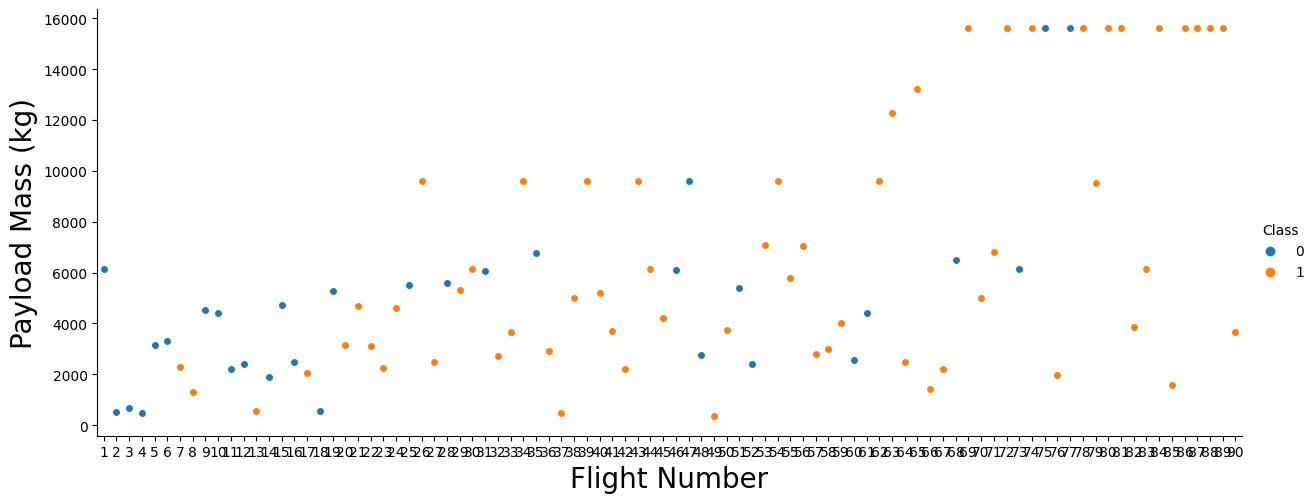

In [54]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect=2.5)
plt.xlabel("Flight Number", fontsize=20)
plt.ylabel("Payload Mass (kg)", fontsize=20)
plt.show()

We see that different launch sites have different success rates.  <code>CCAFS LC-40</code>, has a success rate of 60 %, while  <code>KSC LC-39A</code> and <code>VAFB SLC 4E</code> has a success rate of 77%.

Next, let's drill down to each site visualize its detailed launch records.

### TASK 1: Visualize the relationship between Flight Number and Launch Site

Use the function <code>catplot</code> to plot <code>FlightNumber</code> vs <code>LaunchSite</code>, set the  parameter <code>x</code>  parameter to <code>FlightNumber</code>,set the  <code>y</code> to <code>Launch Site</code> and set the parameter <code>hue</code> to <code>'class'</code>



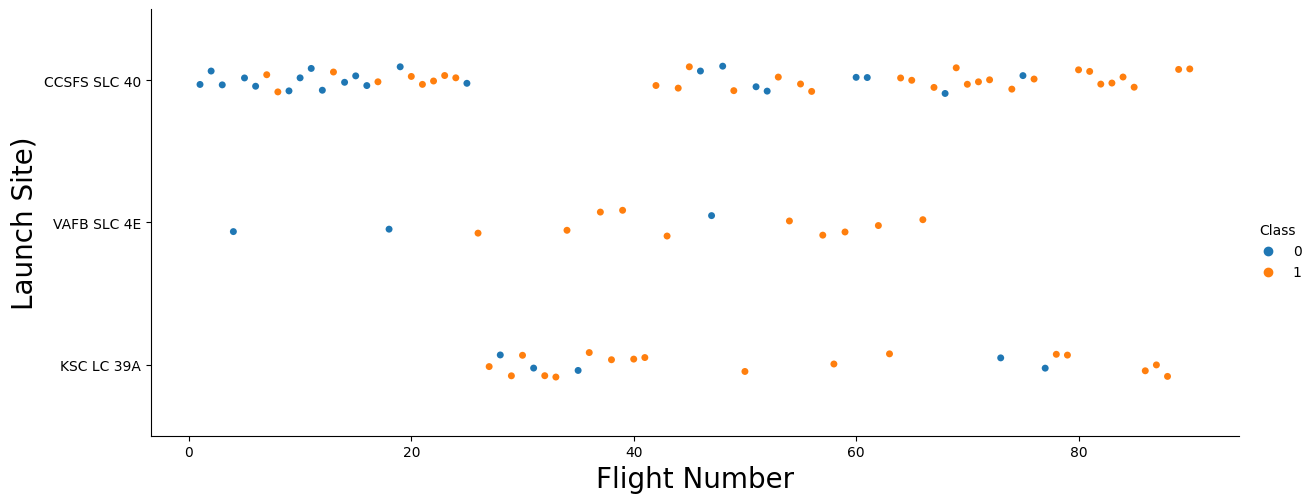

In [55]:
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=df, aspect=2.5)
plt.xlabel("Flight Number", fontsize=20)
plt.ylabel("Launch Site)", fontsize=20)
plt.show()

Now try to explain the patterns you found in the Flight Number vs. Launch Site scatter point plots.

### TASK 2: Visualize the relationship between Payload and Launch Site
We also want to observe if there is any relationship between launch sites and their payload mass.

Plot a scatter point chart with x axis to be Pay Load Mass (kg) and y axis to be the launch site, and hue to be the class value

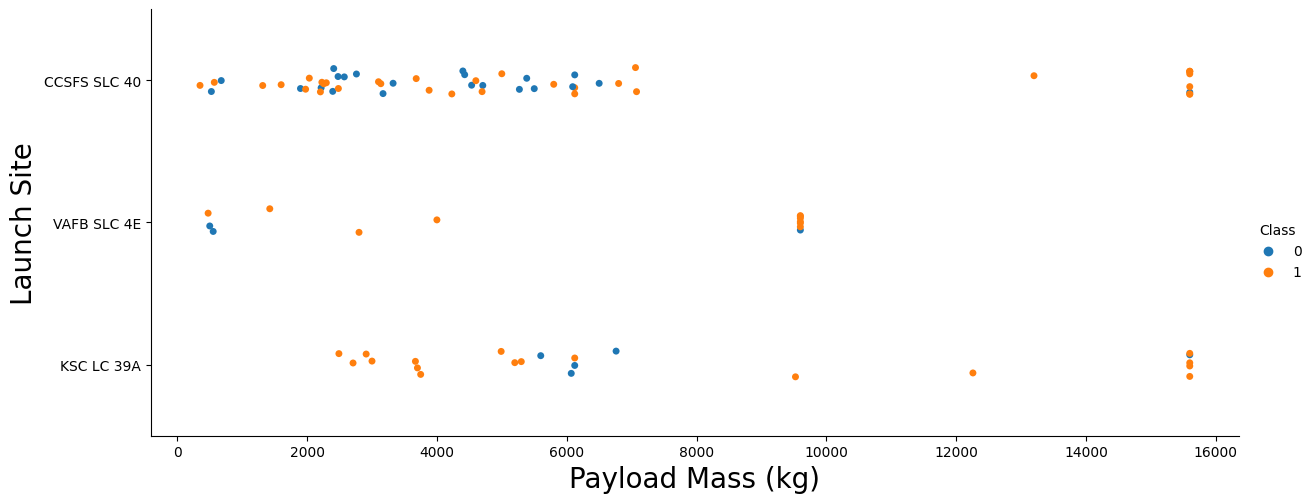

In [56]:
sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=df, aspect=2.5)
plt.xlabel("Payload Mass (kg)", fontsize=20)
plt.ylabel("Launch Site", fontsize=20)
plt.show()

Now if you observe Payload Vs. Launch Site scatter point chart you will find for the VAFB-SLC launchsite there are no rockets launched for heavypayload mass(greater than 10000).

### TASK 3: Visualize the relationship between success rate of each orbit type
Next, we want to visually check if there are any relationship between success rate and orbit type.

Let's create a bar chart for the sucess rate of each orbit

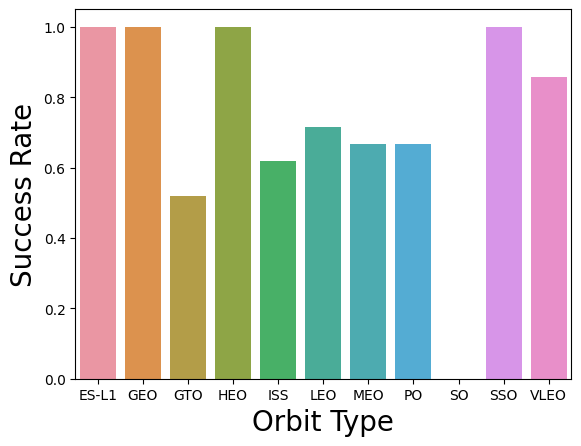

In [57]:
df_orbit = df.groupby(df['Orbit'], as_index=False).agg({"Class": "mean"})
#df_orbit
sns.barplot(y="Class", x="Orbit", data=df_orbit)
plt.xlabel("Orbit Type", fontsize=20)
plt.ylabel("Success Rate", fontsize=20)
plt.show()

### TASK 4: Visualize the relationship between FlightNumber and Orbit type
For each orbit, we want to see if there is any relationship between FlightNumber and Orbit type.

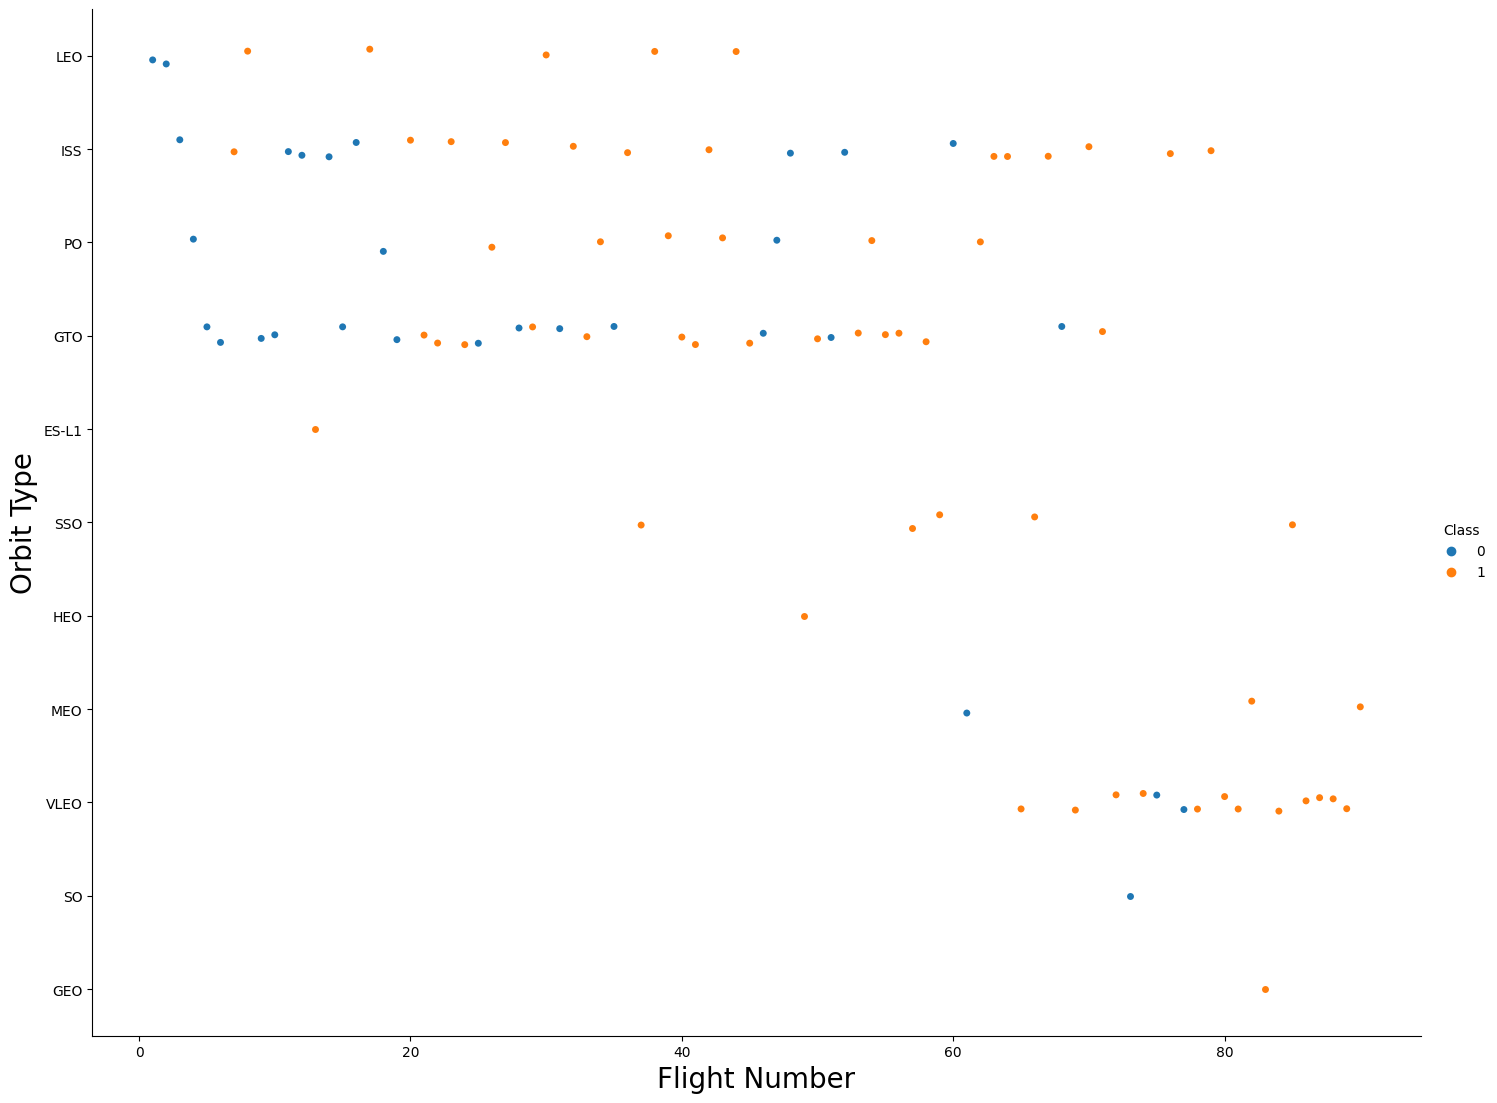

In [58]:
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=df, aspect=1.3, height=11)
plt.xlabel("Flight Number", fontsize=20)
plt.ylabel("Orbit Type", fontsize=20)
plt.show()

You should see that in the LEO orbit the Success appears related to the number of flights; on the other hand, there seems to be no relationship between flight number when in GTO orbit.

### TASK 5: Visualize the relationship between Payload and Orbit type
Similarly, we can plot the Payload vs. Orbit scatter point charts to reveal the relationship between Payload and Orbit type

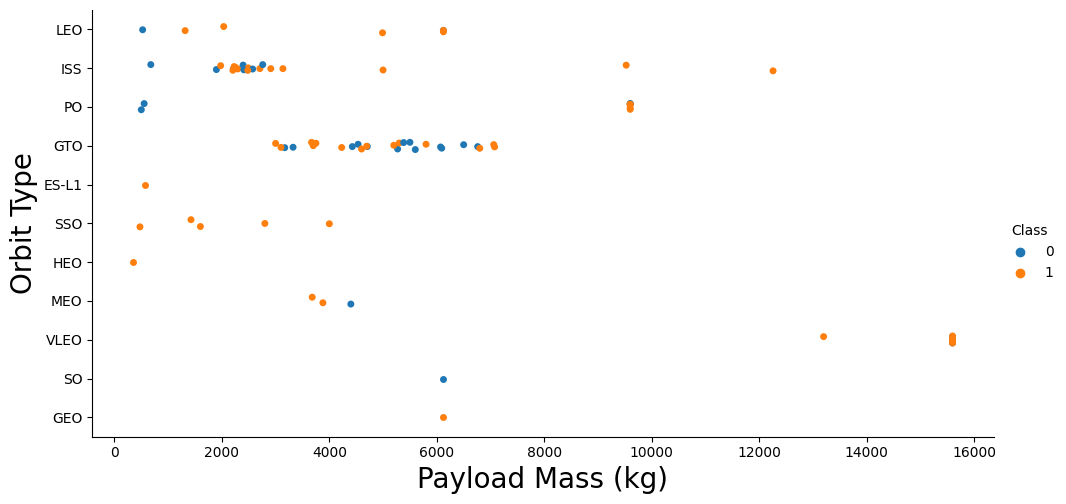

In [59]:
sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=df, aspect=2)
plt.xlabel("Payload Mass (kg)", fontsize=20)
plt.ylabel("Orbit Type", fontsize=20)
plt.show()

With heavy payloads the successful landing or positive landing rate are more for Polar,LEO and ISS.

However for GTO we cannot distinguish this well as both positive landing rate and negative landing(unsuccessful mission) are both there here.

### TASK 6: Visualize the launch success yearly trend
You can plot a line chart with x axis to be Year and y axis to be average success rate, to get the average launch success trend.

The function will help us get the year from the date:

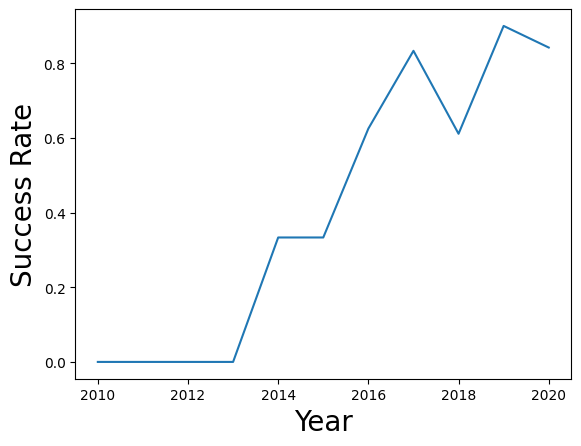

In [60]:
# add year column
df["Year"] = pd.DatetimeIndex(df["Date"]).year.astype(int)

df_year = df.groupby(df['Year'], as_index=False).agg({"Class": "mean"})
#df_orbit
sns.lineplot(y="Class", x="Year", data=df_year)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Success Rate", fontsize=20)
plt.show()


We can observe that the sucess rate since 2013 kept increasing till 2020

### Feature Engineering¶
By now, we have obtained some preliminary insights about how each important variable would affect the success rate, we will select the features that will be used in success prediction in the future module.

#### Note
We have retrospectively added the column <code>Class</code> as it will be needed in EDA (Lab 7) 

In [61]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Class']]
features.head()


,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Class
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003,0
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005,0
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007,0
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003,0
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004,0


### TASK 7: Create dummy variables to categorical columns
Use the function get_dummies and features dataframe to apply OneHotEncoder to the column Orbits, LaunchSite, LandingPad, and Serial. Assign the value to the variable features_one_hot, display the results using the method head. Your result dataframe must include all features including the encoded ones.

#### Note
We have retrospectively added the column <code>Class</code> as it will be needed in EDA (Lab 7) 

In [62]:
features_one_hot = pd.get_dummies(features[['Orbit', 'LaunchSite', 'LandingPad', 'Serial']])
features_one_hot = pd.concat([features[['FlightNumber', 'PayloadMass', 'Flights','GridFins', 'Reused', 'Legs', 'Block', 'ReusedCount', 'Class']], features_one_hot], axis=1)
features_one_hot.head(10)

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Class,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1,6123.547647,1,False,False,False,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,525.000000,1,False,False,False,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,3,677.000000,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4,500.000000,1,False,False,False,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,5,3170.000000,1,False,False,False,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,6,3325.000000,1,False,False,False,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,7,2296.000000,1,False,False,True,1.0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,8,1316.000000,1,False,False,True,1.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,9,4535.000000,1,False,False,False,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,10,4428.000000,1,False,False,False,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### TASK 8: Cast all numeric columns to float64
Now that our features_one_hot dataframe only contains numbers cast the entire dataframe to variable type float64

In [63]:
features_one_hot = features_one_hot.astype(float)
features_one_hot.dtypes


FlightNumber    float64
PayloadMass     float64
Flights         float64
GridFins        float64
Reused          float64
                 ...   
Serial_B1056    float64
Serial_B1058    float64
Serial_B1059    float64
Serial_B1060    float64
Serial_B1062    float64
Length: 81, dtype: object

In [64]:
# features_one_hot.to_csv('dataset_part_3.csv', index=False)
# note that the feature "Class" has been added, since it will be needed in Lab 7
df_fe = features_one_hot

<p id="assignmentfolium" />

## Lab 5: Interactive Visual Analytics with Folium

### Launch Sites Locations Analysis with Folium

The launch success rate may depend on many factors such as payload mass, orbit type, and so on. It may also depend on the location and proximities of a launch site, i.e., the initial position of rocket trajectories. Finding an optimal location for building a launch site certainly involves many factors and hopefully we could discover some of the factors by analyzing the existing launch site locations.

In the previous exploratory data analysis labs, you have visualized the SpaceX launch dataset using matplotlib and seaborn and discovered some preliminary correlations between the launch site and success rates. In this lab, you will be performing more interactive visual analytics using Folium.

### Objectives
This lab contains the following tasks:

- TASK 1: Mark all launch sites on a map
- TASK 2: Mark the success/failed launches for each site on the map
- TASK 3: Calculate the distances between a launch site to its proximities

After completed the above tasks, you should be able to find some geographical patterns about launch sites.

Let's first import required Python packages for this lab:

In [65]:
!pip3 install wget
!pip3 install folium
import folium
import wget
import pandas as pd
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [66]:
# Download and read the `spacex_launch_geo.csv`
spacex_csv_file = wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
spacex_df=pd.read_csv(spacex_csv_file)
print(spacex_df.info())
# print(spacex_df)


100% [............................................................] 7710 / 7710<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flight Number      56 non-null     int64  
 1   Date               56 non-null     object 
 2   Time (UTC)         56 non-null     object 
 3   Booster Version    56 non-null     object 
 4   Launch Site        56 non-null     object 
 5   Payload            56 non-null     object 
 6   Payload Mass (kg)  56 non-null     float64
 7   Orbit              56 non-null     object 
 8   Customer           56 non-null     object 
 9   Landing Outcome    56 non-null     object 
 10  class              56 non-null     int64  
 11  Lat                56 non-null     float64
 12  Long               56 non-null     float64
dtypes: float64(3), int64(2), object(8)
memory usage: 5.8+ KB
None


In [67]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


Above coordinates are just plain numbers that can not give you any intuitive insights about where are those launch sites. If you are very good at geography, you can interpret those numbers directly in your mind. If not, that's fine too. Let's visualize those locations by pinning them on a map.

We first need to create a folium Map object, with an initial center location to be NASA Johnson Space Center at Houston, Texas.

In [68]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

# Create a red circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a red circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

...and you should find a small red circle near the city of Houston and you can zoom-in to see a larger circle.

Now, let's add a circle for each launch site in data frame launch_sites

TODO: Create and add `folium.Circle` and `folium.Marker` for each launch site on the site map

An example of folium.Circle:

`folium.Circle(coordinate, radius=1000, color='#000000', fill=True).add_child(folium.Popup(...))`

An example of folium.Marker:

`folium.map.Marker(coordinate, icon=DivIcon(icon_size=(20,20),icon_anchor=(0,0), html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'label', ))`

In [69]:
# Initialize map
center_coords = [launch_sites_df[['Lat']].max() * 0.5 + launch_sites_df[['Lat']].min() * 0.5, launch_sites_df[['Long']].max() * 0.5 + launch_sites_df[['Long']].min() * 0.5]
site_map = folium.Map(location=center_coords, zoom_start=4)

# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
for _, launch_site in launch_sites_df.iterrows():
    coord = [launch_site['Lat'], launch_site['Long']]
    ls_name = launch_site['Launch Site']
    # print(ls_name, coord)
    # Create a blue circle at site's coordinate with a popup label showing its name
    circle = folium.Circle(coord, radius=1000, color='#0054d3', fill=True).add_child(folium.Popup(ls_name))
    # Create a blue circle at site's coordinate with a icon showing its name
    marker = folium.map.Marker(
        coord,
        # Create an icon as a text label
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:#0054d3;"><b>%s</b></div>' % ls_name,
            )
        )
    site_map.add_child(circle)
    site_map.add_child(marker)

site_map  # display map


Now, you can explore the map by zoom-in/out the marked areas , and try to answer the following questions:

- Are all launch sites in proximity to the Equator line? no (+-30°N)
- Are all launch sites in very close proximity to the coast? yes


### Task 2: Mark the success/failed launches for each site on the map
Next, let's try to enhance the map by adding the launch outcomes for each site, and see which sites have high success rates. Recall that data frame spacex_df has detailed launch records, and the class column indicates if this launch was successful or not

In [70]:
spacex_df.tail(10)

,Launch Site,Lat,Long,class
46,KSC LC-39A,28.573255,-80.646895,1
47,KSC LC-39A,28.573255,-80.646895,1
48,KSC LC-39A,28.573255,-80.646895,1
49,CCAFS SLC-40,28.563197,-80.576820,1
50,CCAFS SLC-40,28.563197,-80.576820,1
51,CCAFS SLC-40,28.563197,-80.576820,0
52,CCAFS SLC-40,28.563197,-80.576820,0
53,CCAFS SLC-40,28.563197,-80.576820,0
54,CCAFS SLC-40,28.563197,-80.576820,1
55,CCAFS SLC-40,28.563197,-80.576820,0


Next, let's create markers for all launch records. If a launch was successful (class=1), then we use a green marker and if a launch was failed, we use a red marker (class=0)

Note that a launch only happens in one of the four launch sites, which means many launch records will have the exact same coordinate. Marker clusters can be a good way to simplify a map containing many markers having the same coordinate.

Let's first create a MarkerCluster object

In [71]:
marker_cluster = MarkerCluster().add_to(site_map)

TODO: Create a new column in launch_sites dataframe called marker_color to store the marker colors based on the class value

In [72]:
# Function to assign color to launch outcome
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)
spacex_df.tail(10)

,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


TODO: For each launch result in spacex_df data frame, add a folium.Marker to marker_cluster

In [73]:
# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# create a Marker object with its coordinate
# and customize the Marker's icon property to indicate if this launch was successed or failed, 
# e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for index, record in spacex_df.iterrows():
    # TODO: Create and add a Marker cluster to the site map
    # marker = folium.Marker(...)
    
    folium.Marker(
        location=[record['Lat'], record['Long']],
        icon=folium.Icon(color=record['marker_color'], icon_color=record['marker_color'],
        popup=record['class'])
    ).add_to(marker_cluster)

site_map

From the color-labeled markers in marker clusters, you should be able to easily identify which launch sites have relatively high success rates.

### TASK 3: Calculate the distances between a launch site to its proximities
Next, we need to explore and analyze the proximities of launch sites.

Let's first add a MousePosition on the map to get coordinate for a mouse over a point on the map. As such, while you are exploring the map, you can easily find the coordinates of any points of interests (such as railway)

In [74]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

Now zoom in to a launch site and explore its proximity to see if you can easily find any railway, highway, coastline, etc. Move your mouse to these points and mark down their coordinates (shown on the top-left) in order to the distance to the launch site.

You can calculate the distance between two points on the map based on their Lat and Long values using the following method:

In [75]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

TODO: Mark down a point on the closest coastline using MousePosition and calculate the distance between the coastline point and the launch site.

In [76]:
# find coordinate of the closet coastline
# distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)

launch_site_lat, launch_site_lon = 28.563197, -80.576820
coastline_lat, coastline_lon = 28.56319, -80.56785

distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
distance_coastline


0.8762983388668405

TODO: After obtained its coordinate, create a folium.Marker to show the distance

In [77]:
# Create and add a folium.Marker on your selected closest coastline point on the map
# Display the distance between coastline point and launch site using the icon property 
distance_marker = folium.Marker(
   location=[coastline_lat, coastline_lon],
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline),
       )
   )

TODO: Draw a PolyLine between a launch site to the selected coastline point

In [78]:
# Create a `folium.PolyLine` object using the coastline coordinates and launch site coordinate
lines=folium.PolyLine(locations=[[launch_site_lat, launch_site_lon], [coastline_lat, coastline_lon]], weight=1)
site_map.add_child(lines)


TODO: Similarly, you can draw a line betwee a launch site to its closest city, railway, highway, etc. You need to use MousePosition to find the their coordinates on the map first

In [79]:
city_lat, city_lon = 28.53, -81.38  # coords for Orlando

line2=folium.PolyLine(locations=[[launch_site_lat, launch_site_lon], [city_lat, city_lon]], weight=3)
site_map.add_child(line2)


After you plot distance lines to the proximities, you can answer the following questions easily:

Are launch sites in close proximity to railways?
Are launch sites in close proximity to highways?
Are launch sites in close proximity to coastline?
Do launch sites keep certain distance away from cities?

Regarding Kennedy Space Center: Distance to highways, cities and railways is good enough, also regarding the fact that rockets will head towards the east.

Regarding Vandenberg AFB: The only larger place to the East of the AFB is Lompoc, CA. 

## Lab 6: Interactive Dashboard

<br /><a href="https://github.com/karaklis/dash_py/blob/main/spacex_dash_app.py">External Link to Assignment: Interactive Dashboard with Dash/Plotly</a>


<p id="assignmentpred" />

## Lab 7: Machine Learning Prediction

### Objectives

Perform exploratory Data Analysis and determine Training Labels
- create a column for the class
- Standardize the data
- Split into training data and test data
- Find best Hyperparameter for SVM, Classification Trees and Logistic Regression
- Find the method performs best using test data


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing as prep 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV  # find best hyperparameters
# classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [81]:
# This function is to plot the confusion matrix
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['did not land', 'land'])
    ax.yaxis.set_ticklabels(['did not land', 'landed'])
    

In [82]:
# If you were unable to complete the previous lab correctly you can uncomment and load this csv
# data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_2.csv')
data = df_wrangled
data.head()


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class,Year
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0,2010
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0,2012
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0,2013
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0,2013
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0,2013


In [83]:
# If you were unable to complete the previous lab correctly you can uncomment and load this csv
# X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_3.csv')

X = df_fe.reset_index().drop(['index'], axis=1)
X.head(100)

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Class,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15600.000000,2.0,1.0,1.0,1.0,5.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
86,87.0,15600.000000,3.0,1.0,1.0,1.0,5.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
87,88.0,15600.000000,6.0,1.0,1.0,1.0,5.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### TASK 1
Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).

#### Note
The column <code>Class</code> is not available in the downloadable csv-file, nor in the original dataframe. It actually got lost in the process of feature engineering. Hence, I have edited the corresponding lab to make it available here.


In [84]:
# It seems weird to convert a column to a numpy array, then reconvert it to a pandas series
# we can immediately extract the pandas series from the dataframe
y = X['Class']
X.drop(['Class'], axis=1, inplace=True)
type(y)

pandas.core.series.Series

### TASK 2
Standardize the data in X then reassign it to the variable X using the transform provided below.

In [85]:
X = prep.StandardScaler().fit_transform(X)
X

array([[-1.71291154,  0.        , -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-1.67441914, -1.18972425, -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-1.63592675, -1.15742336, -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       ...,
       [ 1.63592675,  2.01380177,  3.49060516, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [ 1.67441914,  2.01380177,  1.00389436, ..., -0.21566555,
         5.38516481, -0.10599979],
       [ 1.71291154, -0.51905572, -0.65391284, ..., -0.21566555,
        -0.18569534,  9.43398113]])

We split the data into training and testing data using the function train_test_split. The training data is divided into validation data, a second set used for training data; then the models are trained and hyperparameters are selected using the function GridSearchCV.

## TASK 3
Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to 0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
y_test.shape
# we have 18 samples

(18,)

### TASK 4
Create a logistic regression object then create a GridSearchCV object logreg_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.


In [87]:
# details of parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
parameters = {"C":[0.01,0.1,1], 'penalty':['l2'], 'solver':['lbfgs']}  
lr = LogisticRegression()

logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X, y)
logreg_cv.best_estimator_

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8222222222222222


### TASK 5

Calculate the accuracy on the test data using the method score:

In [88]:
print('score on train data: ', logreg_cv.score(X_train, y_train))  # R² score on train data
print('score on test data : ', logreg_cv.score(X_test, y_test))  # R² score on test data


score on train data:  0.9722222222222222
score on test data :  0.9444444444444444


Lets look at the confusion matrix:

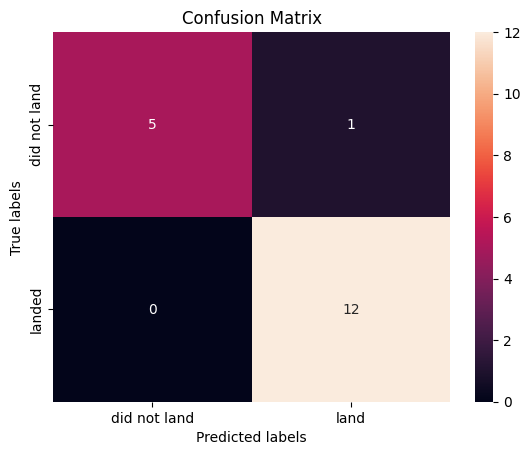

In [89]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes. We see that the major problem is false positives.

### TASK 6
Create a support vector machine object then create a GridSearchCV object svm_cv with cv - 10. Fit the object to find the best parameters from the dictionary parameters.

In [90]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}  # from 10^-3 to 10^3 in 6 steps with equal quotients
svm = SVC()

svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X, y)
svm_cv.best_estimator_

print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8333333333333334


In [91]:
print('score on train data: ', svm_cv.score(X_train, y_train))  # R² score on train data
print('score on test data : ', svm_cv.score(X_test, y_test))  # R² score on test data

score on train data:  0.9027777777777778
score on test data :  0.9444444444444444


### TASK 7
Calculate the accuracy on the test data using the method score:

In [92]:
print('score on train data: ', svm_cv.score(X_train, y_train))  # R² score on train data
print('score on test data : ', svm_cv.score(X_test, y_test))  # R² score on test data


score on train data:  0.9027777777777778
score on test data :  0.9444444444444444


We can plot the confusion matrix

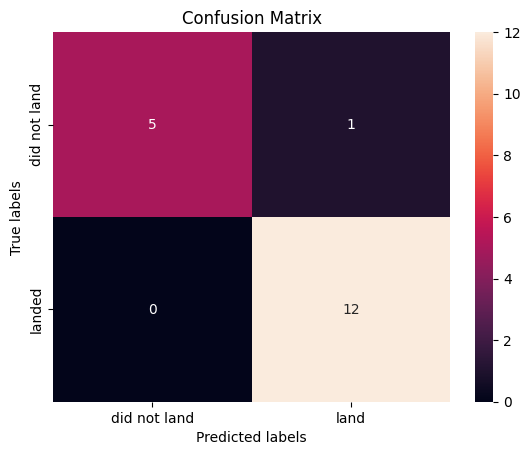

In [93]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

### TASK 8
Create a decision tree classifier object then create a GridSearchCV object tree_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.

In [94]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X, y)
tree_cv.best_estimator_

print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)


/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warning

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
accuracy : 0.8666666666666668


/home/asif/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


### TASK 9
Calculate the accuracy of tree_cv on the test data using the method score:

In [95]:
print('score on train data: ', tree_cv.score(X_train, y_train))  # R² score on train data
print('score on test data : ', tree_cv.score(X_test, y_test))  # R² score on test data


score on train data:  0.9444444444444444
score on test data :  0.9444444444444444


### TASK 10¶
Create a k nearest neighbors object then create a GridSearchCV object knn_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.

In [96]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X, y)
knn_cv.best_estimator_

print("tuned hpyerparameters :(best parameters) ", knn_cv.best_params_)
print("accuracy :", knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 8, 'p': 1}
accuracy : 0.8


### TASK 11
Calculate the accuracy of knn_cv on the test data using the method score:

In [97]:
print('score on train data: ', knn_cv.score(X_train, y_train))  # R² score on train data
print('score on test data : ', knn_cv.score(X_test, y_test))  # R² score on test data

score on train data:  0.8333333333333334
score on test data :  0.8888888888888888


We can plot the confusion matrix

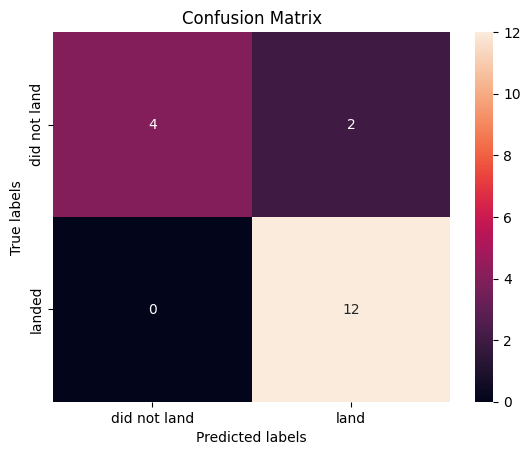

In [98]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

### TASK 12

Find the method performs best:

Scores on test data for each method
- Logistic Regression: 0.944
- SVM: 0.944
- Decision Tree: 0.888
- KNN: 0.888

Conclusion: Logistic Regression and SVM deliver the best performance on test data.